In [201]:
import chainer.serializers
chainer.serializers.load_npz('micro_generator',generator)
chainer.serializers.load_npz('micro_discriminator',discriminator)
###### you could directly use the generator and discriminator after loading

In [1]:
import scipy.io as sio
import numpy as np
data1=sio.loadmat('data1_th.mat')['final_1'][0:100]
data2=sio.loadmat('data2_th.mat')['final_2'][0:100]
data3=sio.loadmat('data3_th.mat')['final_3'][0:100]
X_train_ct=np.concatenate((data1,data2,data3), axis=0)

In [2]:
import argparse
import numpy as np
from chainer import datasets, cuda, serializers, Variable
from chainer import optimizers as O
from chainer import functions as F
from models import Generator, Discriminator


# def rnd_categorical(n, n_categorical):
#     indices = np.random.randint(n_categorical, size=n)
#     one_hot = np.zeros((n, n_categorical))
#     one_hot[np.arange(n), indices] = 1
#     return one_hot, indices


def rnd_categorical(n, n_categorical):
    indices = np.random.randint(n_categorical, size=n)
    one_hot = np.zeros((n, n_categorical-13))
    for i in range(n):
        if indices[i]==2:
            one_hot[i, :]=[1,0,0]
        elif indices[i]==1:
            one_hot[i, :]=[0,1,0]
        elif indices[i]==0:
            one_hot[i, :]=[0,0,1]
    return one_hot, indices

# def rnd_categorical(n,n_categorical):
#     indices = np.random.randint(n_categorical, size=n)
#     one_hot = np.zeros((n, n_categorical))
#     for i in range(n):
#         one_hot[i,:]=[np.random.binomial(1, 0.5, 1)[0],np.random.binomial(1, 0.5, 1)[0],np.random.binomial(1, 0.5, 1)[0],
#                      np.random.binomial(1, 0.5, 1)[0]]
#     return one_hot, indices
    
    

def rnd_continuous(n, n_continuous, mu=0, std=1):
    return np.random.normal(mu, std, size=(n, n_continuous))



#args = parse_args()
#gpu = args.gpu
n_z = 0
n_categorical = 16
n_continuous = 4
max_epochs = 10000
batch_size = 100
#out_generator_filename = args.out_generator_filename

# Prepare the training data
#     train, _ = datasets.get_mnist(withlabel=False, ndim=2)
#     train_size = train[0:1000].shape[0]
#     im_shape = train.shape[1:]

train=X_train_ct/1.
train=train.reshape(300,28,28)
train_size = train[0:300].shape[0]
im_shape = train.shape[1:]


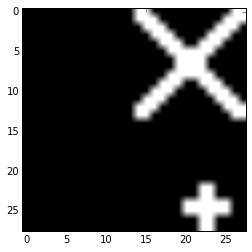

In [3]:
import random
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(data1[0].reshape(28,28),'gray')

In [9]:
# # Prepare the models
# generator = Generator(n_z + 3 + n_continuous, im_shape)
# generator_optimizer = O.Adam(alpha=1e-3, beta1=0.5)
# generator_optimizer.setup(generator)

# discriminator = Discriminator(im_shape, n_categorical, n_continuous)
# discriminator_optimizer = O.Adam(alpha=2e-4, beta1=0.5)
# discriminator_optimizer.setup(discriminator)

# xp = np

for epoch in range(max_epochs):
    generator_epoch_loss = np.float32(0)
    discriminator_epoch_loss = np.float32(0)

    for i in range(0, train_size, batch_size):
        # Sample noise z
        zs = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)

        # Sample a category encoded as a one-hot vector to hopefully learn a digit
        c_categorical, categories = rnd_categorical(batch_size, n_categorical)
        
        c_categorical = xp.asarray(c_categorical, dtype=xp.float32)
        categories = xp.asarray(categories, dtype=xp.int32)

        # Sample continuous codes to learn rotation, thickness, etc.
        c_continuous = xp.asarray(rnd_continuous(batch_size, n_continuous), dtype=xp.float32)

        zc = xp.concatenate((zs, c_categorical, c_continuous), axis=1)

        # Forward
        x_fake = generator(zc)
        y_fake, mi = discriminator(x_fake)

        x_real = xp.zeros((batch_size, 28,28), dtype=xp.float32)
        for xi in range(len(x_real)):
            x_real[xi] = xp.array(train[np.random.randint(train_size)])
        
        x_real = xp.expand_dims(x_real, 1)
        y_real, _ = discriminator(x_real)

        # Losses
        generator_loss = F.softmax_cross_entropy(y_fake, xp.ones(batch_size, dtype=xp.int32))
        discriminator_loss = F.softmax_cross_entropy(y_fake, xp.zeros(batch_size, dtype=xp.int32))
        discriminator_loss += F.softmax_cross_entropy(y_real, xp.ones(batch_size, dtype=xp.int32))

        # Mutual Information loss
        mi_categorical, mi_continuous_mean = F.split_axis(mi, [n_categorical], 1)

        # Categorical loss
        categorical_loss = F.softmax_cross_entropy(mi_categorical, categories, use_cudnn=False)
        

        # Continuous loss - Fix standard deviation to 1, i.e. log variance is 0
        mi_continuous_ln_var = xp.empty_like(mi_continuous_mean.data, dtype=xp.float32)
        mi_continuous_ln_var.fill(1)
        # mi_continuous_ln_var.fill(1e-6)
        continuous_loss = F.gaussian_nll(mi_continuous_mean, Variable(c_continuous), Variable(mi_continuous_ln_var))
        continuous_loss /= batch_size

        generator_loss += categorical_loss
        generator_loss += continuous_loss

        # Backprop
        generator_optimizer.zero_grads()
        generator_loss.backward()
        generator_optimizer.update()

        discriminator_optimizer.zero_grads()
        discriminator_loss.backward()
        discriminator_optimizer.update()

        generator_epoch_loss += generator_loss.data
        discriminator_epoch_loss += discriminator_loss.data

    generator_avg_loss = generator_epoch_loss / train_size
    discriminator_avg_loss = discriminator_epoch_loss / train_size

    print('Epoch {} Loss Generator: {} Loss Discriminator: {}'
          .format(epoch + 1, generator_avg_loss, discriminator_avg_loss))


print('Finished training')

Epoch 1 Loss Generator: 0.155218149821 Loss Discriminator: 7.08423554897e-05
Epoch 2 Loss Generator: 0.159115142822 Loss Discriminator: 8.91716281573e-05
Epoch 3 Loss Generator: 0.155907109578 Loss Discriminator: 8.25799877445e-05
Epoch 4 Loss Generator: 0.158964055379 Loss Discriminator: 6.55821710825e-05
Epoch 5 Loss Generator: 0.154736671448 Loss Discriminator: 7.89888203144e-05
Epoch 6 Loss Generator: 0.157111536662 Loss Discriminator: 7.190361619e-05
Epoch 7 Loss Generator: 0.156638437907 Loss Discriminator: 4.88995884856e-05
Epoch 8 Loss Generator: 0.163483835856 Loss Discriminator: 3.67347896099e-05
Epoch 9 Loss Generator: 0.156969604492 Loss Discriminator: 7.68491004904e-05
Epoch 10 Loss Generator: 0.155542055766 Loss Discriminator: 7.64500225584e-05
Epoch 11 Loss Generator: 0.157753067017 Loss Discriminator: 0.000306930964192
Epoch 12 Loss Generator: 0.157968330383 Loss Discriminator: 6.10676594079e-05
Epoch 13 Loss Generator: 0.158911921183 Loss Discriminator: 7.61204957962e-

KeyboardInterrupt: 

In [11]:
mi_categorical.shape, mi_continuous_mean.shape

((100L, 16L), (100L, 4L))

(array([ 701.,    7.,    0.,    0.,    3.,    5.,    2.,    4.,   19.,   43.]),
 array([ 0.        ,  0.09996541,  0.19993081,  0.29989622,  0.39986162,
         0.49982703,  0.59979243,  0.69975784,  0.79972324,  0.89968865,
         0.99965405]),
 <a list of 10 Patch objects>)

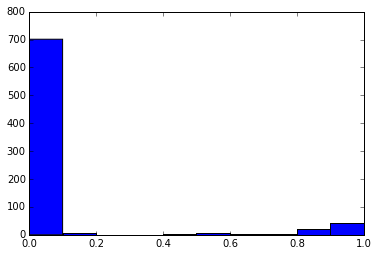

In [5]:
plt.hist(generator(zc).data[0].reshape(-1))

In [152]:
F.bernoulli_nll(mi_continuous_mean[0], Variable(c_continuous[0]))

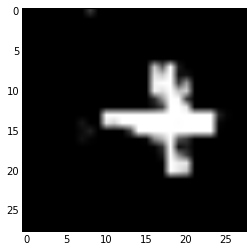

In [10]:
import random
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(generator(zc).data[5].reshape(28,28),'gray')

In [88]:
discriminator(x_real)

(<variable at 0x33e8d710>, <variable at 0x33e8d7f0>)

In [57]:
test[0].reshape(28,28).shape

(28L, 28L)

In [64]:
test=sio.loadmat('test_data.mat')['test']
test=np.asarray(test.reshape(100,1,28,28), dtype=np.float32)
test.shape
test_y,test_mi=discriminator(test)

In [104]:
test=np.asarray(data1.reshape(100,1,28,28), dtype=np.float32)
test_y,test_mi=discriminator(test)

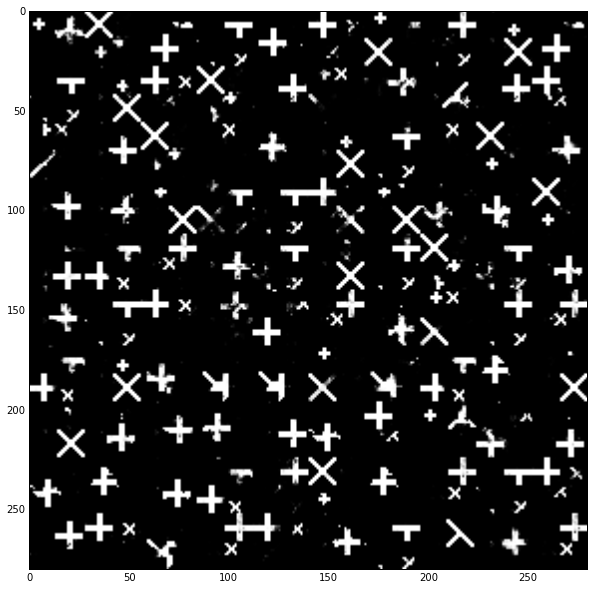

In [11]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

#z=np.random.uniform(-1, 1, (100, 62)).astype(np.float32)

c2=np.zeros((100,2))
grid_y = np.linspace(-1, 1, 10)
for j, xi in enumerate(grid_y):
    c2[j,0]=xi
        
#for i, yi in enumerate(grid_x):
for j, xi in enumerate(grid_y):
    for i, yi in enumerate(grid_x):
        z=np.random.uniform(-1, 1, (100, 0)).astype(np.float32)
        c1=np.zeros((100,n_categorical))
        c1[:,1]=1
        c2=xp.asarray(rnd_continuous(100, n_continuous), dtype=xp.float32)
        z_test = np.concatenate((z, c1, c2), axis=1)
        z_sample = zc
        z_sample=z_sample.astype(np.float32)
        #print i
        x_decoded = generator(z_sample).data[i+j*10]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]


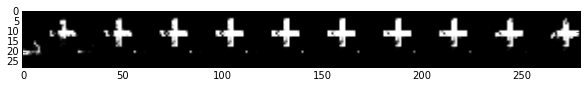

In [18]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((28, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, 16)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)
c_categorical2 = np.zeros((batch_size,n_categorical-13), dtype=np.float32)
for ii in range(100):
    roll=random.randint(0,n_categorical-14)
    c_categorical2[ii,roll]=1
c_categorical2[0,:]=0
c_categorical2[0,:]=0
c_categorical2[0,2]=1
c_continuous2 = xp.asarray(rnd_continuous(100, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
#for i, yi in enumerate(grid_x):
for j, xi in enumerate(grid_y):
    #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
    c_continuous2[0,:]=np.array([[xi, 0,0,0]], dtype=np.float32)
    c_categorical2[0]=c_categorical2[0]
    print c_categorical2[0]
    zc2 = xp.concatenate((c_categorical2, c_continuous2), axis=1)  
    x_decoded = generator(zc2).data[0]
    digit = x_decoded.reshape(digit_size, digit_size)

    figure[0:28,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [10]:
z_sample[0]

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.80320573,
        0.95572871,  1.07984722,  2.41886544], dtype=float32)

In [71]:
test=sio.loadmat('test_data.mat')['test']
data1=sio.loadmat('data1_th.mat')['final_1'][0:100]
data2=sio.loadmat('data2_th.mat')['final_2'][0:100]
data3=sio.loadmat('data3_th.mat')['final_3'][0:100]
test=np.asarray(test.reshape(100,1,28,28), dtype=np.float32)
data1=np.asarray(data1.reshape(100,1,28,28), dtype=np.float32)
data2=np.asarray(data2.reshape(100,1,28,28), dtype=np.float32)
data3=np.asarray(data3.reshape(100,1,28,28), dtype=np.float32)

test_y,test_mi=discriminator(test)
data1_y,data1_mi=discriminator(data1)
data2_y,data2_mi=discriminator(data2)
data3_y,data3_mi=discriminator(data3)


In [128]:
print X_input.shape
print Y_lab.shape

(300L, 20L)
(300L, 3L)


In [131]:
clf = svm.SVC()
clf.fit(X_input[0:150], y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import tree

X_input=np.concatenate((data1_mi.data,data2_mi.data,data3_mi.data), axis=0)
Y_temp=np.array([[1,1,0],[0,1,0],[0,1,1]])
Y_lab=np.repeat(Y_temp, [100,100,100], axis=0)
clf = tree.DecisionTreeClassifier()
clf.fit(X_input,Y_lab)
Result=clf.predict(test_mi.data)


In [189]:
Result1=clf.predict(data1_mi.data)

In [190]:
k_1=0
for i in range(100):
    if sum(abs([1,1,0] - Result1[i]))==0:
        k_1=k_1+1 
print k_1

100


In [153]:
k_3=0
for i in range(100):
    if sum(abs([0,1,1] - Result[i]))==0:
        k_3=k_3+1
print k_1
print k_2 
print k_3

25
40
35


In [ ]:
1+1

In [162]:
data1_mi.data.shape

(100L, 20L)

In [181]:
classes = model.predict_classes(test_mi.data)
classes

 32/100 [========>.....................] - ETA: 0s

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1], dtype=int64)